# Shrinkage and hierarchical inference with selection effects

_Boris Leistedt, January 2017_

This notebook is available at [this location on Github](https://github.com/ixkael/Prob-tools/blob/master/notebooks/Shrinkage%20and%20hierarchical%20inference%20with%20selection%20effects.ipynb). 

In this notebook we will make a simple hierarchical probabilistic model and illustrate:

- the shrinkage of uncertainties on individual objects in the presence of population parameters,
- the way the likelihood function must be modified to account for selection effects (here a cut on the signal-to-noise ratio of the data points),
- use Hamiltonian Monte Carlo to perform a very efficient parameter inference

### Requirements

Some basic knowledge of Bayes theorem, parameter inference via MCMC, hierarchical probabilistic models, and Hamiltonian Monte Carlo.

You will need `matplotlib`, `scipy`, `numpy`,
and `daft` if you want to draw the graphical model.

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

import numpy as np
import scipy.special
from scipy.misc import derivative

import daft

rc("font", family="serif", size=14)
rc("text", usetex=True)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['patch.linewidth'] = 2
matplotlib.rcParams['axes.prop_cycle'] =\
    cycler("color", ['k', 'c', 'm', 'y'])
matplotlib.rcParams['axes.labelsize'] = 16

## Setup
Our model will consist of:
- one population parameter $\alpha$, describing the distribution of values $x$ via $p(x|\alpha)$,
- a set of $N$ true (unobserverd, or latent) variables $\{x_i\}_{i=1, \cdots, N}$ drawn from $p(x|\alpha)$,
- a set of $N$ noisy, observed variables $\{y_i\}_{i=1, \cdots, N}$ drawn from $p(y|x, sigma)$,
- a set of noise levels, described by $\sigma_i$, which are given / fixed,
- a selection effect S, for example a cut on signal-to-noise ratio (SNR) applied to the noisy variables $\{y_i\}$.

Let us draw the model corresponding to this description: 

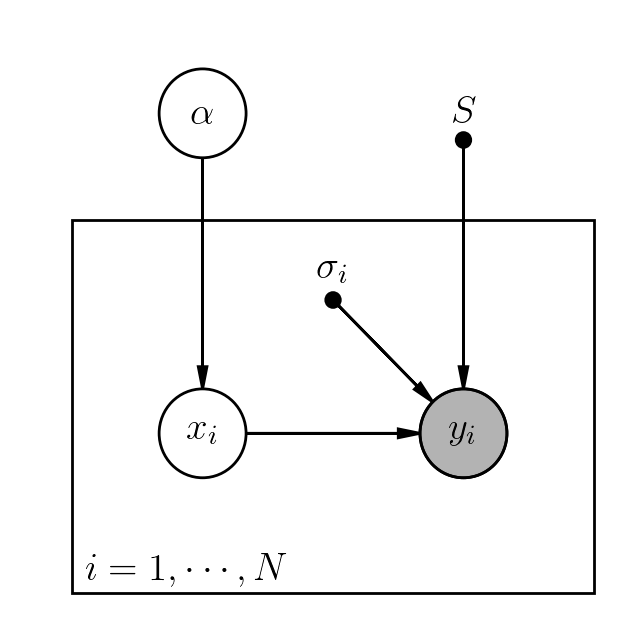

In [2]:
pgm = daft.PGM([2.3, 2.25], origin=[0.3, 0.3], grid_unit=3)
pgm.add_node(
    daft.Node("alpha", r"$\alpha$", 1, 2.2))
pgm.add_node(
    daft.Node("S", r"$S$", 2, 2.1, fixed=True))
pgm.add_node(
    daft.Node("sigma_i", r"$\sigma_i$",1.5, 1.5, fixed=True))
pgm.add_node(
    daft.Node("x_i", r"$x_i$", 1, 1))
pgm.add_node(
    daft.Node("y_i", r"$y_i$", 2, 1, observed=True))
pgm.add_plate(
    daft.Plate([0.5, 0.5, 2, 1.3], label=r"$i = 1, \cdots, N$", shift=-0.1))
pgm.add_edge("S", "y_i")
pgm.add_edge("alpha", "x_i")
pgm.add_edge("x_i", "y_i")
pgm.add_edge("sigma_i", "y_i")
pgm.render(interactive=False)
pgm.figure.set_size_inches(3, 3)
rc("font", family="serif", size=10)

## Parameter inference (without selection effects)

We want to infer $\alpha$ and $\{ x_i \}_{i=1, \cdots, N}$ from $\{ y_i \}_{i=1, \cdots, N}$.

The posterior distribution on those parameters, via Bayes' theorem applied to the hierarchical model, is:

$p(\alpha, \{ x_i \} | \{ y_i \}, S) \propto p(\alpha) \prod_{i=1}^N p(x_i|\alpha)p(y_i|x_i)$

The denominator (the evidence, or marginalized likelihood) can be dropped since it is constant w.r.t. the parameters of interest. We are only interested in exploring the interesting region of the posterior distribution, not its overall scale (which we would need for model comparison/selection).

$p(y_i|x_i)$ is the likelihood function. $p(x_i|\alpha)p$ is the population model, $p(\alpha)$ the prior.

## Parameter inference (with selection effects)

We now assume that the data $\{ y_i \}_{i=1, \cdots, N}$ have been selected according to a selection effect or cut which will affect the parameters of interest (otherwise it would not affect any of the probabilisties and it could be dropped).

The posterior distribution on the parameters is now:

$p(\alpha, \{ x_i \} | \{ y_i \}, S) \propto p(\alpha) \prod_{i=1}^N p(x_i|\alpha)p(y_i|x_i,S)$

The term $p(y_i|x_i,S)$ is a new likelihood function (a slight abuse of terminology), modified by selection effects:

$p(y_i|x_i,S) = \frac{ p(S | y_i) p(y_i|x_i) }{ p(S | x_i ) }$

The term 
$p(S | y_i) = \frac{ p(y_i | S) p(S) }{p(y_i)}$
is constant. The real selection function is implemented in $p(y_i | S)$.

The other term,

$p(S | x_i ) = \int \mathrm{d}y^\prime_i p(S | y^\prime_i) p(y^\prime_i|x_i)$,

captures the way the original likelihood function is modified due to selection effects.

## Example: Gaussian noise and SNR cut

In many cases, we will have 

$p(y_i|x_i,S) \propto \frac{ p(y_i|x_i) } { \int \mathrm{d}y^\prime_i p(y^\prime_i | S) p(y^\prime_i|x_i)}$,

when the selection effects are simple and deterministic.

We now consider a simple signal-to-noise ratio (SNR) cut, with some threshold $C$: 
    
$p(y_i | S) = 1$ if $y_i/\sigma_i > C$, otherwise $0$.

We also consider Gaussian noise, so that the likelihood function is simply

$p(y_i|x_i) = \mathcal{N}(y_i-x_i;\sigma_i)$.

With this deterministic cut, the correction term of interest, $p( S | x_i )$, is a convolution:

$p(S | x_i ) = \int_{C\sigma_i}^{\infty} \mathrm{d}y^\prime_i \mathcal{N}(y^\prime_i-x_i;\sigma_i)$,

leading to

$p( S | x_i ) \propto 1 - \mathrm{erf}( \frac{C\sigma_i - x_i}{\sqrt{2}\sigma_i} ) $

So the final result, our new likelihood function for the hierarchical model, is

$p(y_i|x_i,S) \propto \frac{ \exp(-\frac{1}{2}(\frac{y_i-x_i}{\sigma_i})^2) }{ 1 - \mathrm{erf}( \frac{C\sigma_i - x_i}{\sqrt{2}\sigma_i} ) }$

where are have dropped irrelevant multiplicative constant terms everywhere.

## Lets test that with a simulation!

Let's generate $x_i$'s from a Gaussian centered at $\alpha$, then add noise.

Let's also apply a SNR cut, i.e. only keep objects that satisfy some SNR criterion.

We will infer $\alpha$ (and the $\{x_i\}_{i=1, \cdots, N}$) with the framework presented above.

We will check that neglecting the selection effects leads to a biased answer, 
and that the formulae above correctly mitigates this bias.

In [3]:
nobj = 1000 
alpha, sigma_alpha = 10, 1 # some arbitrary values
x_i = alpha + sigma_alpha * np.random.randn(nobj) # Gaussian draws 
sigma_i = np.random.uniform(sigma_alpha, sigma_alpha * 2, size=nobj) # uniform draws
y_i = x_i + sigma_i * np.random.randn(nobj)  # Gaussian draws from N(x_i, sigma_i)
# some grid for computing and plotting p(x|alpha), here a Gaussian.
x_grid = np.linspace(np.min(y_i), np.max(y_i), 100)
p_x_alpha_grid = np.exp(-0.5*((x_grid-alpha)/sigma_alpha)**2)/\
    np.sqrt(2*np.pi)/sigma_alpha

Let's plot the initial distribution and the samples (with and without noise):

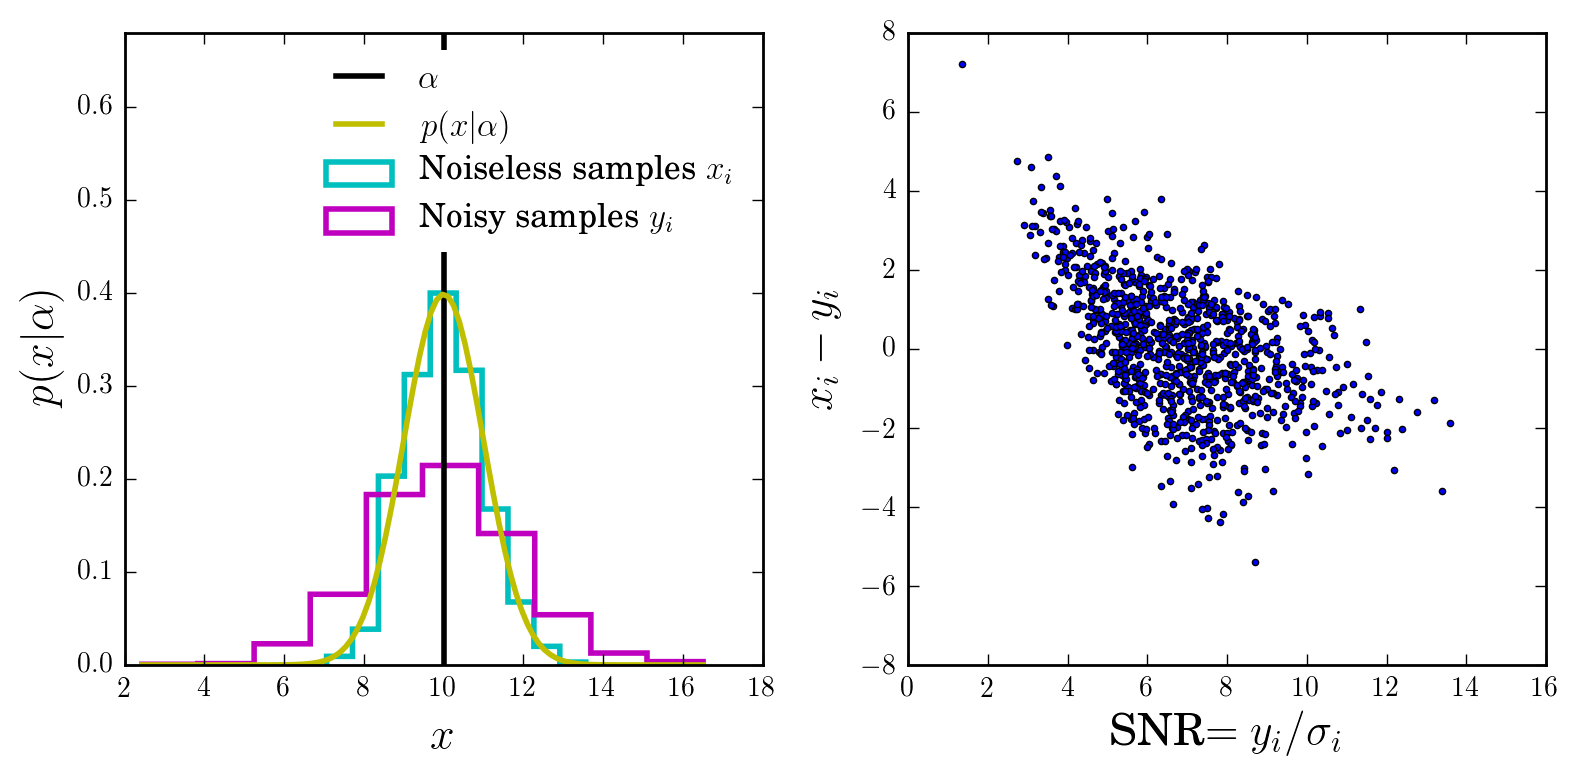

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].axvline(alpha, label=r'$\alpha$',
               color=next(axs[0]._get_lines.prop_cycler)['color'])
axs[0].hist(x_i, histtype='step', normed=True,
           label=r'Noiseless samples $x_i$')
axs[0].hist(y_i, histtype='step', normed=True,
           label=r'Noisy samples $y_i$')
axs[0].plot(x_grid, p_x_alpha_grid, label=r'$p(x | \alpha)$')
axs[0].legend(frameon=True).get_frame().set_linewidth(0)
axs[0].set_ylim([0, axs[0].get_ylim()[1]*1.7])
axs[0].set_ylabel(r'$p(x|\alpha)$')
axs[0].set_xlabel(r'$x$')
axs[1].scatter(y_i/sigma_i, x_i-y_i, lw=0.5, s=5)
axs[1].set_xlabel(r'SNR$=y_i/\sigma_i$')
axs[1].set_ylabel(r'$x_i-y_i$')
fig.tight_layout()

In [5]:
snrcut = 5 # our SNR cut
sel = np.where(y_i / sigma_i > snrcut)[0]
print(sel.size, "objects on", nobj, 'satisfy the SNR cut')

848 objects on 1000 satisfy the SNR cut


Let's apply the SNR cut and visualise the resulting distribution of samples:

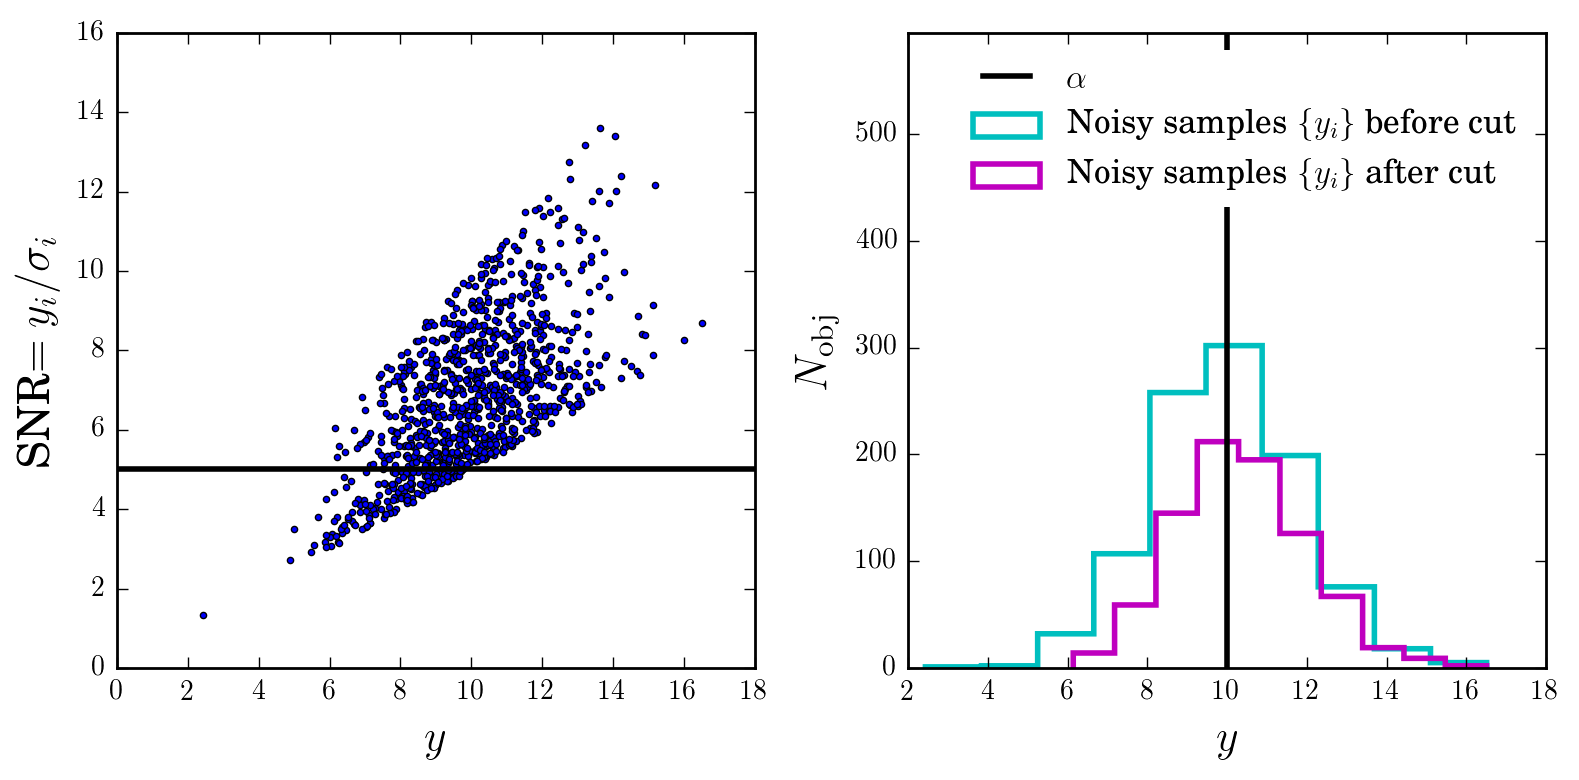

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].axhline(snrcut, label='SNR cut',
               color=next(axs[0]._get_lines.prop_cycler)['color'])
axs[0].scatter(y_i, y_i / sigma_i, lw=0.5, s=5)
axs[0].set_ylabel(r'SNR$=y_i/\sigma_i$')
axs[0].set_xlabel(r'$y$')

axs[1].axvline(alpha, label=r'$\alpha$',
               color=next(axs[1]._get_lines.prop_cycler)['color'])
axs[1].hist(y_i, histtype='step', normed=False,
           label=r'Noisy samples $\{y_i\}$ before cut')
axs[1].hist(y_i[sel], histtype='step', normed=False,
           label=r'Noisy samples $\{y_i\}$ after cut')
axs[1].legend(frameon=True).get_frame().set_linewidth(0)
axs[1].set_ylim([0, axs[1].get_ylim()[1]*1.7])
axs[1].set_ylabel(r'$N_\mathrm{obj}$')
axs[1].set_xlabel(r'$y$')
fig.tight_layout()

## Intuition
We can already see that by applying the cut we are biasing ourselves towards higher values of $\alpha$.

However, there is enough data (think coverage in $x$ or $y$) and we the selection cut, so we could hope to invert this effect. 

And indeed, the equations we derived above show that it is possible in theory.

## Parameter inference 

Let us now write and test the various ingredients we need for the inference: the likelihood function $p(y|x,\sigma)$, the population model $p(x|\alpha)$, and the selection effect $p(S|x)$. 

Note that we will use minus log probabilities, and that we will also need their gradients for the Hamiltonian Monte Carlo sampler.

In [7]:
def lngaussian(x, mu, sig):
    return 0.5*((x-mu)/sig)**2 + 0.5*np.log(2*np.pi) + np.log(sig)

def lngaussian_grad(x, mu, sig):
    return (x-mu)/sig**2

def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2) / np.sqrt(2*np.pi) / sig

def lnselectioneffect(xs, sigmas, snrcut):
    fac = 0.5 * (1 - scipy.special.erf((snrcut*sigmas - xs)/np.sqrt(2)/sigmas))
    res = np.sum(np.log(fac))
    return res

def lnselectioneffect_grad(xs, sigmas, snrcut):
    fac = 0.5 * (1 - scipy.special.erf((snrcut*sigmas - xs)/np.sqrt(2)/sigmas))
    res = gaussian(snrcut*sigmas, xs, sigmas) / fac
    return res

# evaluate posterior distribution without SNR cut
def lnprob_without_seffect(params, ys=y_i, sigmas=sigma_i,
                           sigma_alphav=sigma_alpha, snrcutv=snrcut):
    assert params.size == ys.size + 1
    assert params.size == sigmas.size + 1
    alphav, xs = params[0], params[1:]
    res = np.sum(lngaussian(xs, alphav, sigma_alphav))
    res += np.sum(lngaussian(xs, ys, sigmas))
    return res

# evaluate gradients of posterior distribution without SNR cut
def lnprob_without_seffect_grad(params, ys=y_i, sigmas=sigma_i,
                                sigma_alphav=sigma_alpha, snrcutv=snrcut):
    alphav, xs = params[0], params[1:]
    res = 0*params
    res[0] = - np.sum(lngaussian_grad(xs, alphav, sigma_alphav))
    res[1:] = lngaussian_grad(xs, alpha, sigma_alphav)
    res[1:] += lngaussian_grad(xs, ys, sigmas)
    return res

# evaluate posterior distribution with SNR cut
def lnprob_with_seffect(params, ys=y_i, sigmas=sigma_i,
                        sigma_alphav=sigma_alpha, snrcutv=snrcut):
    alphav, xs = params[0], params[1:]
    res = lnprob_without_seffect(params, ys=ys, sigmas=sigmas,
                                 sigma_alphav=sigma_alphav)
    res += lnselectioneffect(xs, sigmas, snrcutv)
    return res

# evaluate gradients of posterior distribution with SNR cut
def lnprob_with_seffect_grad(params, ys=y_i, sigmas=sigma_i,
                             sigma_alphav=sigma_alpha, snrcutv=snrcut):
    alphav, xs = params[0], params[1:]
    res = lnprob_without_seffect_grad(params, ys=ys, sigmas=sigmas,
                                      sigma_alphav=sigma_alphav)
    res[1:] += lnselectioneffect_grad(xs, sigmas, snrcutv)
    return res

Let's now run a set of numerical tests to check that our analytic gradients 
match the numerical gradients of the likelihood functions.

In [8]:
relative_accuracy = 0.01
params = np.concatenate((np.array([alpha]), x_i))
kwargs = {'ys': y_i, 'sigmas': sigma_i,
          'sigma_alphav': sigma_alpha, 'snrcutv': snrcut}

grads_without_seffect = lnprob_without_seffect_grad(params, **kwargs)
grads_with_seffect = lnprob_with_seffect_grad(params, **kwargs)
grads_seffect = lnselectioneffect_grad(x_i, sigma_i, snrcut)
minval = 1e-10

for i in range(nobj + 1):
    
    def f(v):
        params2 = 1*params
        params2[i] = v
        return lnprob_without_seffect(params2, **kwargs)

    grads2 = derivative(f, params[i], dx=0.001*params[i], order=5)
    if grads2 > minval:
        np.testing.assert_allclose(grads2,
                                   grads_without_seffect[i],
                                   rtol=relative_accuracy)
    
    if i < nobj:
        def f(v):
            x_i2 = 1*x_i
            x_i2[i] = v
            return lnselectioneffect(x_i2, sigma_i, snrcut)

        grads2 = derivative(f, x_i[i], dx=0.001*x_i[i], order=5)
        if grads2 > minval:
            np.testing.assert_allclose(grads2,
                                       grads_seffect[i],
                                       rtol=relative_accuracy)
    
    def f(v):
        params2 = 1*params
        params2[i] = v
        return lnprob_with_seffect(params2, **kwargs)

    grads2 = derivative(f, params[i], dx=0.001*params[i], order=5)
    if grads2 > minval:
        np.testing.assert_allclose(grads2,
                                   grads_with_seffect[i],
                                   rtol=relative_accuracy)

## The new likelihoods

Let us now look at the new likelihood functions $p(y_i|x_i, S)$ and compare them to the original ones, $p(y_i|x_i)$, which ignore selection effects. 

As expected, the correction term boosts the distribution at the low values of $x$.

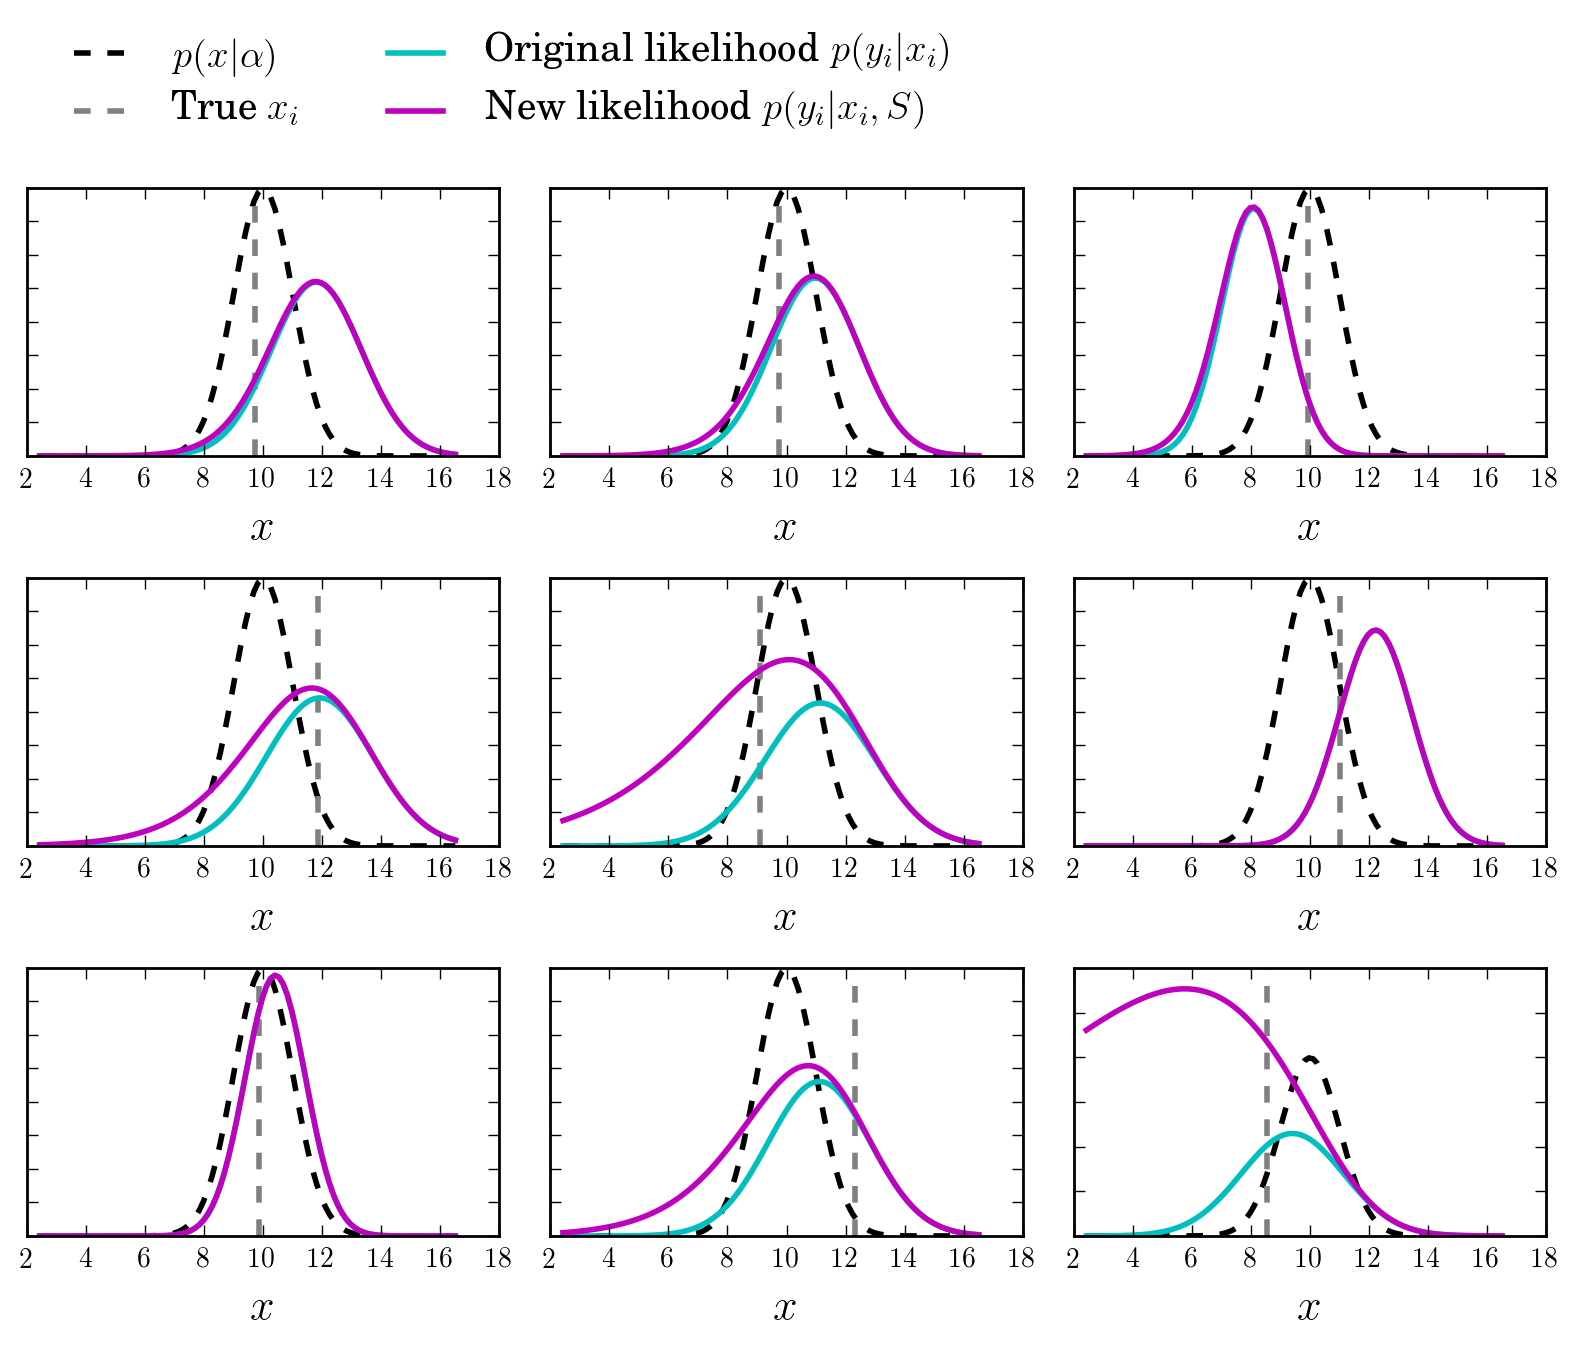

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(8, 6))
axs = axs.ravel()

for ax, i in zip(axs, np.random.choice(sel, axs.size, replace=False)):
    like = np.exp(-0.5*((y_i[i] - x_grid)/sigma_i[i])**2)/np.sqrt(2*np.pi)/sigma_i[i]
    like2 = 2 * like /\
        (1 - scipy.special.erf((snrcut*sigma_i[i] - x_grid)/np.sqrt(2)/sigma_i[i]))
    ax.plot(x_grid, p_x_alpha_grid, label=r'$p(x | \alpha)$', ls='dashed')
    ax.axvline(x_i[i], label='True $x_i$', color='gray', ls='dashed')
    ax.plot(x_grid, like, label='Original likelihood $p(y_i|x_i)$')
    ax.plot(x_grid, like2, label='New likelihood $p(y_i|x_i, S)$')
    ax.set_yticklabels([])
    ax.set_xlabel('$x$')
axs[0].legend(ncol=2, frameon=False, loc='upper left',
              bbox_to_anchor=(0.0, 1.7), fontsize=14)
fig.tight_layout()

## Sampling the posterior distributions via Hamiltonian Monte Carlo

Hamiltonian Monte Carlo (HMC) is a great technique for sampling from probability distributions of interest.
It only requires the gradients w.r.t. the parameters of interest to be known analytically or easily computable.

Provided the HMC sampler is tuned, it is very efficient: it has an acceptance probability of one (it is an MCMC that never rejects samples) and efficiently mixes parameters, even in high dimensions.

Given that our model is very simple, has a lot of parameters, and admits simple gradients, it is very natural to opt for HMC to explore the posterior distributions of interest.

In [10]:
# This is the function that performs one HMC sample, 
# with num_steps steps of size step_size relative to the gradient.
# x0 is the initial point, lnprob the posterior distribution, lnprobgrad is gradients.
def hmc_sampler(x0, lnprob, lnprobgrad, step_size,
                num_steps, mass_matrix=None, **kwargs):
    if mass_matrix is None:
        inv_mass_matrix = np.eye(x0.size)
    else:
        assert mass_matrix.size == x0.size**2
        inv_mass_matrix = np.linalg.inv(mass_matrix)
    v0 = np.random.randn(x0.size)
    v = v0 - 0.5 * step_size *lnprobgrad(x0, **kwargs)
    x = x0 + step_size * v
    for i in range(num_steps):
        v = v - step_size * lnprobgrad(x, **kwargs)
        x = x + step_size * v
    v = v - 0.5 * step_size * lnprobgrad(x, **kwargs)
    orig = lnprob(x0, **kwargs)\
        + 0.5 * np.dot(v0.T, np.dot(inv_mass_matrix, v0))
    current = lnprob(x, **kwargs)\
        + 0.5 * np.dot(v.T, np.dot(inv_mass_matrix, v))
    p_accept = min(1.0, np.exp(orig - current))
    if p_accept > np.random.uniform():
        return x
    else:
        return x0

In [11]:
# Number of samples we want
num_samples = 10000
burnin = int(0.3*num_samples)
# Note that we will use stochastic num_steps and step_size for the HMC since this improves mixing.

### First run

Let's run HMC to sample from the posterior distribution of the first model:

no SNR cut (use the full data set) with the correct likelihood function (with no SNR cut).

In [12]:
kwargs = {'ys': y_i, 'sigmas': sigma_i,
          'sigma_alphav': sigma_alpha, 'snrcutv': snrcut}
params_samples_without_seffect = np.zeros((num_samples, nobj + 1))
params_samples_without_seffect[0, :] =\
    np.concatenate((np.array([y_i.mean()]), y_i))
for i in range(1, num_samples):
    step_size = np.random.uniform(1e-4, 1e-2)
    num_steps = np.random.randint(10, 40)
    params_samples_without_seffect[i, :] =\
        hmc_sampler(params_samples_without_seffect[i-1, :],
                    lnprob_without_seffect,
                    lnprob_without_seffect_grad,
                    step_size, num_steps, **kwargs)
params_samples_without_seffect = params_samples_without_seffect[burnin:, :]
params_samples_without_seffect_mean = params_samples_without_seffect.mean(axis=0)
params_samples_without_seffect_std = params_samples_without_seffect.std(axis=0)

And check that the results make sense

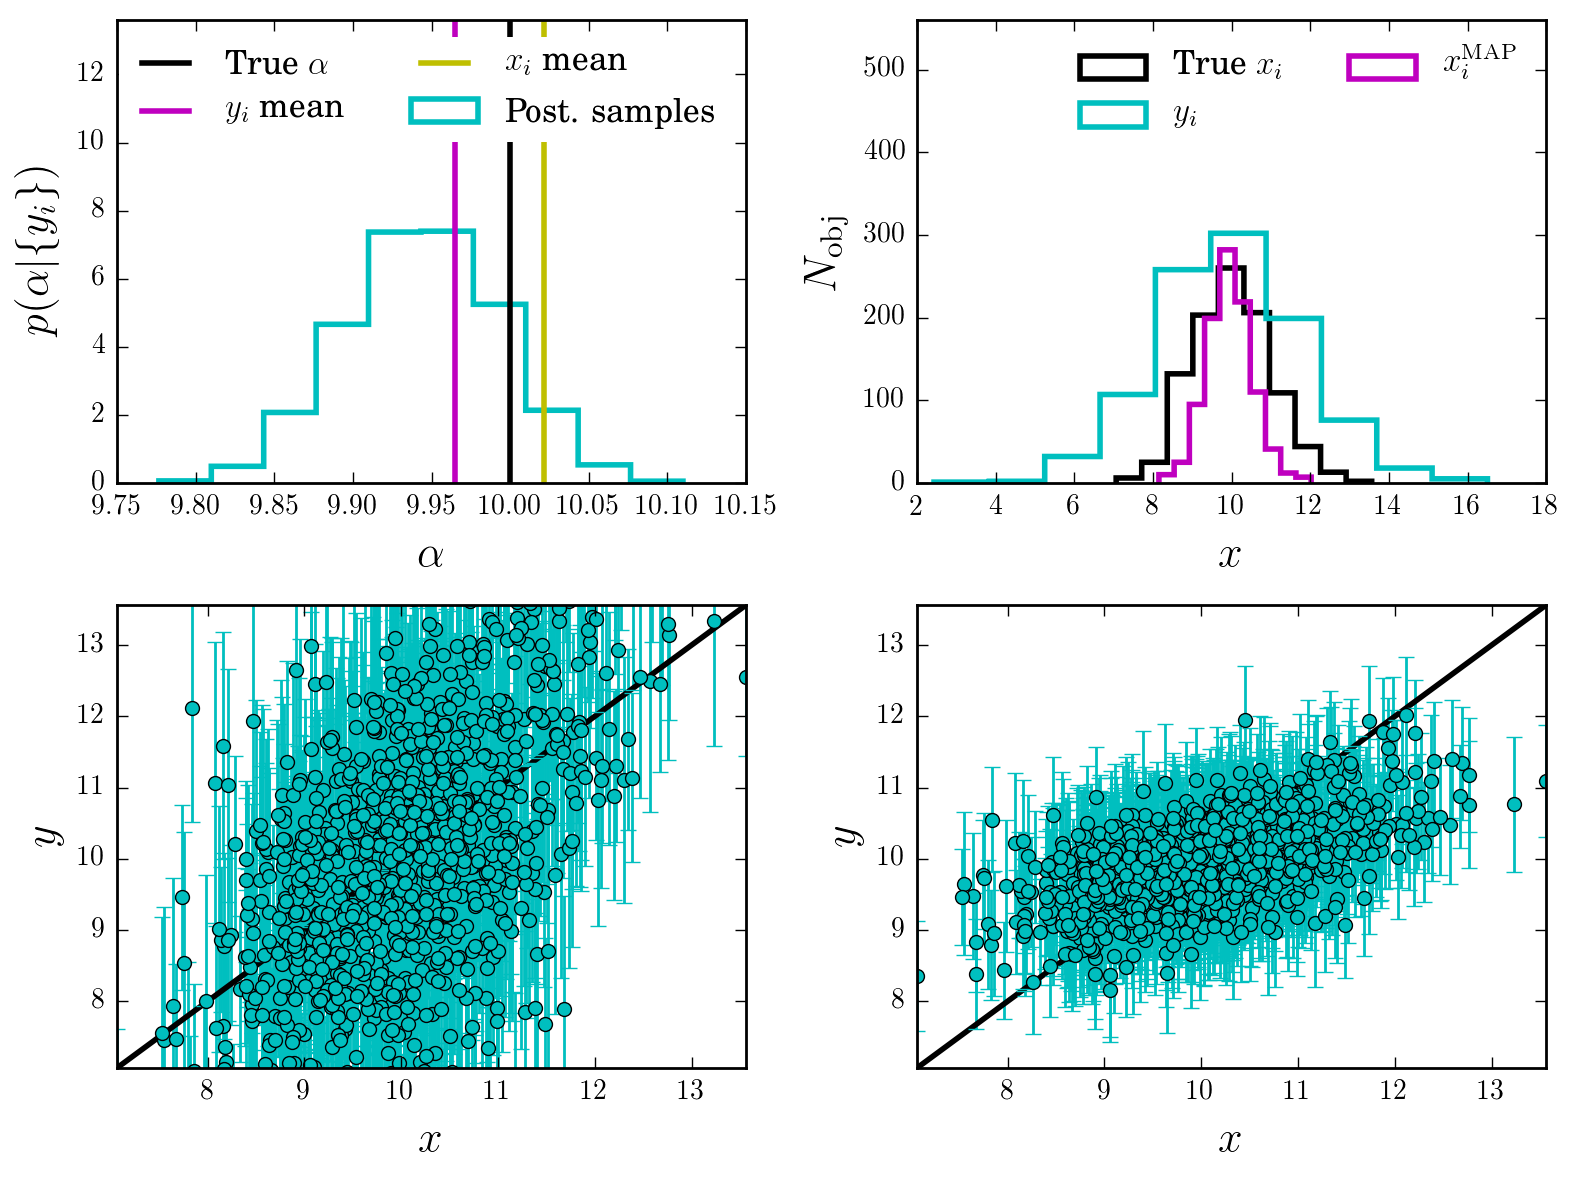

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()
axs[0].axvline(alpha, label='True $\\alpha$',
               color=next(axs[0]._get_lines.prop_cycler)['color'])
axs[0].hist(params_samples_without_seffect[:, 0],
            normed=True, histtype='step', label='Post. samples')
axs[0].axvline(y_i.mean(), label='$y_i$ mean',
               color=next(axs[0]._get_lines.prop_cycler)['color'])
axs[0].axvline(x_i.mean(), label='$x_i$ mean',
               color=next(axs[0]._get_lines.prop_cycler)['color'])
axs[0].legend(ncol=2).get_frame().set_linewidth(0)
axs[0].set_ylim([0, axs[0].get_ylim()[1]*1.7])
axs[0].set_ylabel(r'$p(\alpha | \{ y_i\})$')
axs[0].set_xlabel(r'$\alpha$')

axs[1].hist(x_i, histtype="step", label='True $x_i$')
axs[1].hist(y_i, histtype="step", label='$y_i$')
axs[1].hist(params_samples_without_seffect_mean[1:],
            histtype="step", label='$x_i^\mathrm{MAP}$')
axs[1].legend(ncol=2).get_frame().set_linewidth(0)
axs[1].set_ylim([0, axs[1].get_ylim()[1]*1.6])
axs[1].set_ylabel(r'$N_\mathrm{obj}$')
axs[1].set_xlabel(r'$x$')

x_min, x_max = x_i.min(), x_i.max()
axs[2].plot([x_min, x_max], [x_min, x_max])
axs[2].errorbar(x_i, y_i, yerr=sigma_i,
                fmt="o", markersize=5, lw=1)
axs[2].set_xlim([x_min, x_max])
axs[2].set_ylim([x_min, x_max])
axs[2].set_xlabel(r'$x$')
axs[2].set_ylabel(r'$y$')

axs[3].plot([x_min, x_max], [x_min, x_max])
axs[3].errorbar(x_i, params_samples_without_seffect_mean[1:],
                yerr=params_samples_without_seffect_std[1:],
                fmt="o", markersize=5, lw=1)
axs[3].set_xlim([x_min, x_max])
axs[3].set_ylim([x_min, x_max])
axs[3].set_xlabel(r'$x$')
axs[3].set_ylabel(r'$y$')

fig.tight_layout()

### Interpretation

We see from the first panel that indeed the recover a nice posterior distribution for $\alpha$ (with the $\{ x_i \}$s all marginalized out) capturing the true value.

The other panels show that the $\{ x_i \}$ are also recover, and how the uncertainties significantly shrinkage around the true value, compared to the original likelihood $p(y_i|x_i)$. All we have done is connecting them via the population model $p(x|\alpha)$ and simultaneously infer all the parameters.
This is a nice example of the typical Bayesian Shrinkage (tm) of uncertainties in hierarchical models.

### Second and third runs

Let us now run the sampler on the subset of objects passing the SNR cut.

We will first do a run with the standard likelihood function ignoring selection effects.

We will then do an other run with the correct, selection-corrected likelihood function.

In [14]:
kwargs = {'ys': y_i[sel], 'sigmas': sigma_i[sel],
          'sigma_alphav': sigma_alpha, 'snrcutv': snrcut}
params_samples_with_seffect_negl = np.zeros((num_samples, sel.size + 1))
params_samples_with_seffect_negl[0, :] =\
    np.concatenate((np.array([y_i[sel].mean()]), y_i[sel]))
for i in range(1, num_samples):
    step_size = np.random.uniform(1e-4, 1e-2)
    num_steps = np.random.randint(10, 40)
    params_samples_with_seffect_negl[i, :] =\
        hmc_sampler(params_samples_with_seffect_negl[i-1, :],
                    lnprob_without_seffect,
                    lnprob_without_seffect_grad,
                    step_size, num_steps, **kwargs)
params_samples_with_seffect_negl = params_samples_with_seffect_negl[burnin:, :]
params_samples_with_seffect_negl_mean = params_samples_with_seffect_negl.mean(axis=0)
params_samples_with_seffect_negl_std = params_samples_with_seffect_negl.std(axis=0)

In [15]:
kwargs = {'ys': y_i[sel], 'sigmas': sigma_i[sel],
          'sigma_alphav': sigma_alpha, 'snrcutv': snrcut}
params_samples_with_seffect = np.zeros((num_samples, sel.size + 1))
params_samples_with_seffect[0, :] =\
    np.concatenate((np.array([y_i[sel].mean()]), y_i[sel]))
for i in range(1, num_samples):
    step_size = np.random.uniform(1e-3, 1e-2)
    num_steps = np.random.randint(10, 40)
    params_samples_with_seffect[i, :] =\
        hmc_sampler(params_samples_with_seffect[i-1, :],
                    lnprob_with_seffect,
                    lnprob_with_seffect_grad,
                    step_size, num_steps, **kwargs)
params_samples_with_seffect = params_samples_with_seffect[burnin:, :]
params_samples_with_seffect_mean = params_samples_with_seffect.mean(axis=0)
params_samples_with_seffect_std = params_samples_with_seffect.std(axis=0)

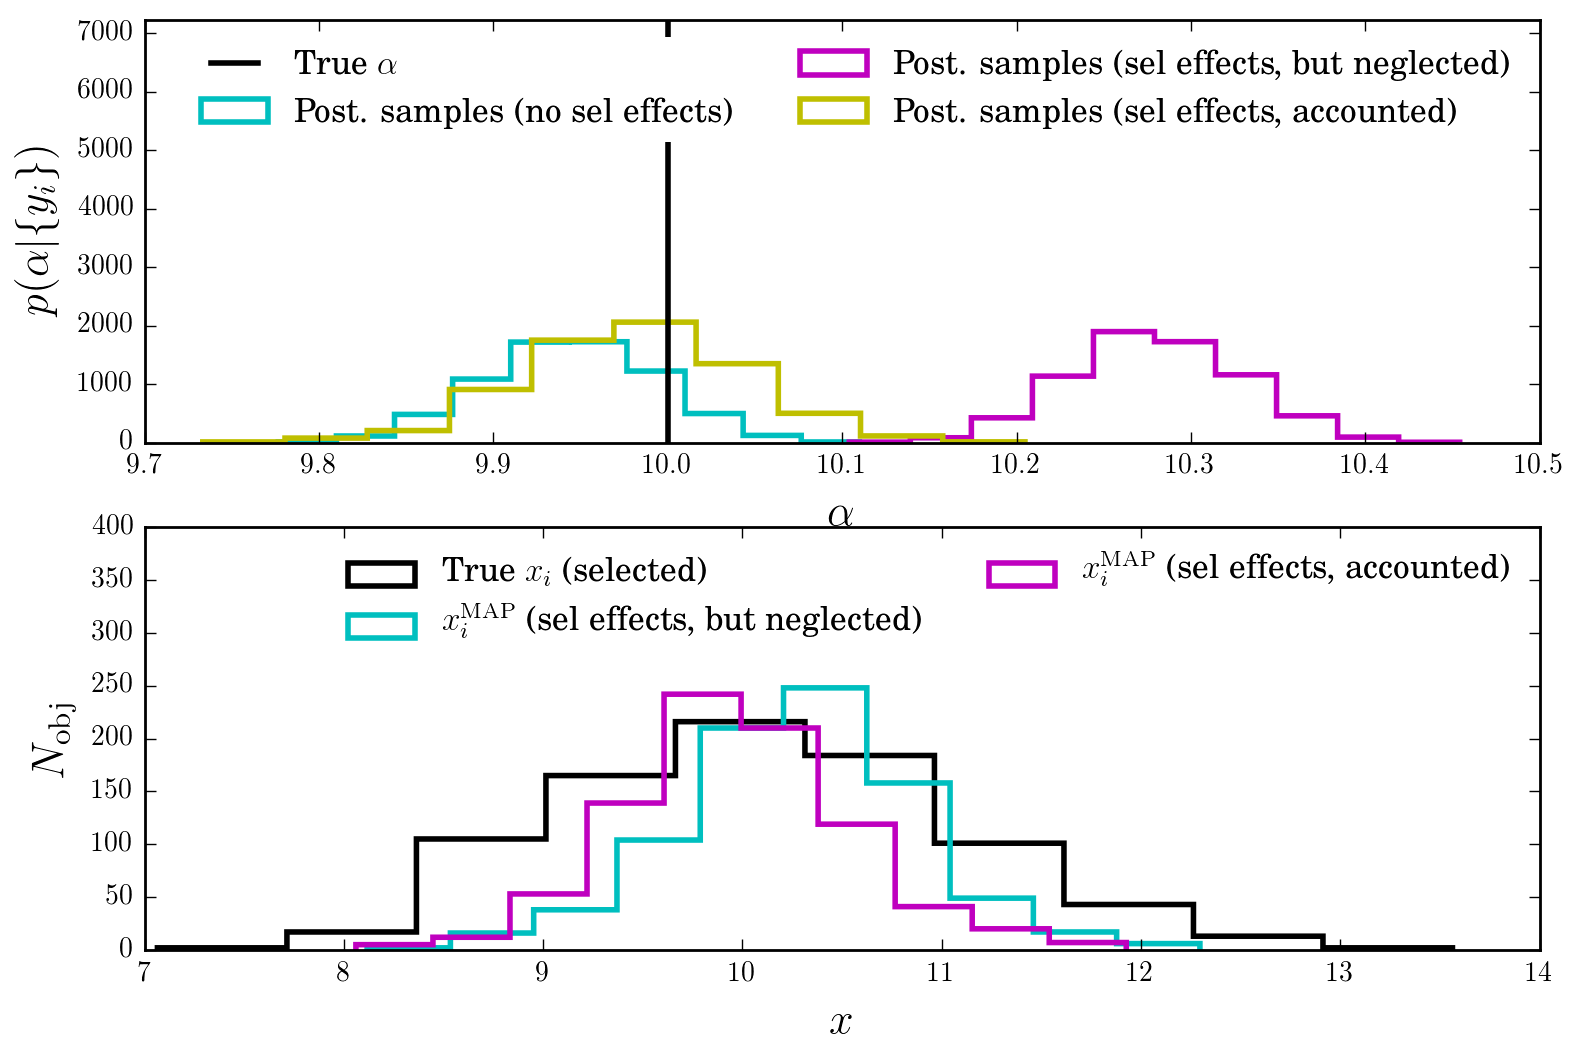

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6))
axs = axs.ravel()
axs[0].axvline(alpha, label='True $\\alpha$',
               color=next(axs[0]._get_lines.prop_cycler)['color'])
axs[0].hist(params_samples_without_seffect[:, 0], histtype='step',
            label='Post. samples (no sel effects)')
axs[0].hist(params_samples_with_seffect_negl[:, 0], histtype='step',
            label='Post. samples (sel effects, but neglected)')
axs[0].hist(params_samples_with_seffect[:, 0], histtype='step',
            label='Post. samples (sel effects, accounted)')
axs[0].set_ylim([0, axs[0].get_ylim()[1]*1.7])
axs[0].set_ylabel(r'$p(\alpha | \{ y_i\})$')
axs[0].set_xlabel(r'$\alpha$')
axs[0].legend(ncol=2).get_frame().set_linewidth(0)
axs[0].set_ylim([0, axs[0].get_ylim()[1]*1.7])

axs[1].hist(x_i[sel], histtype="step", label='True $x_i$ (selected)')
axs[1].hist(params_samples_with_seffect_negl_mean[1:], histtype="step",
            label='$x_i^\mathrm{MAP}$ (sel effects, but neglected)')
axs[1].hist(params_samples_with_seffect_mean[1:], histtype="step",
            label='$x_i^\mathrm{MAP}$ (sel effects, accounted)')
axs[1].legend(ncol=2).get_frame().set_linewidth(0)
axs[1].set_ylim([0, axs[1].get_ylim()[1]*1.6])
axs[1].set_ylabel(r'$N_\mathrm{obj}$')
axs[1].set_xlabel(r'$x$')

### Interpretation

We see that indeed, running the standard likelihood on the SNR-selected objects leads to biased answers for $\alpha$! 

This gets fixed when using the correct likelihood function, which is aware of the SNR cut and attempts to correct it.

Of course, this process has its limits. Here we have used enough data and our knowledge of the selection effect.

# Conclusion

If you've applied cuts to your data, then you most likely have to modify the likelihood function involved in the parameter inference! This might require some math, but it will mitigate the bias arising from using an incorrect likelihood function.